# Local Search: Traveling Salesman Problem

---

**Local search** is a very commonly used heuristic for solving complex combinatorial optimisation problems. We have introduced its basics in a previous [tutorial](https://github.com/meiyi1986/tutorials/blob/master/notebooks/local-search-basics.ipynb).

When applying local search to solve different combinatorial optimisation problems, the **neighbourhood definition** (or **move operators**) is the key to success.

In this tutorial, we will introduce how to design local search to solve the **Traveling Salesman Problem (TSP)**, a very well known combinatorial optimisation problem with many real-world applications in logistics and delivery indutries.

## Traveling Salesman Problem

---

A formal definition of TSP is as follows. Given a set of nodes $\{v_1, ..., v_n\}$ and the cost $c(v_i,v_j)$ from each node $v_i$ to another node $v_j$ ($1 \leq i \neq j \leq n$), the problem is to find a tour with the **minimal total cost** so that

- The tour visits **each node exactly once**, and
- The tour is a **cycle**.

In other words, TSP is to find a **[Hamiltonian Cycle](https://en.wikipedia.org/wiki/Hamiltonian_path)** with the minimal total cost. TSP is known to be NP-complete, and no polynomial-time algorithm can solve it to optimality.

An example of finding the shortest path of drilling 280 holes on a Printed Circuit Board (the `a280.tsp` instance in the [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/) page) along with its optimal solution is shown below. Its total cost is 2579.

<img src="img/tsp-a280-opt.png" width=400 />

## Load `.tsp` Data

---

First, we load a TSP instance data, which is formatted as a `.tsp` file downloadable from the [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/) page. The data contains the id (normall starting from 1), x and y coordinates of each node in the graph. The cost between two nodes is defined as the Euclidean distance.

Below is the method to load a `.tsp` file.

In [6]:
def load_data(file):

    """
    Read a TSP instance from a .tsp file, and returns the coordinates.
    :param file: the .tsp file.
    :return: coordinates
    """

    f = open(file, "r")
    
    # Skip the first information rows until "NODE_COORD_SECTION" is seen
    line = f.readline()
    while not line.__contains__("NODE_COORD_SECTION"):
        line = f.readline()

    # Read the coordinate section
    coord = {}

    line = f.readline()
    while not line.__contains__("EOF"):
        line_elements = line.split()
        id = int(line_elements[0])
        x = float(line_elements[1])
        y = float(line_elements[2])
        coord[id] = [x, y]
        line = f.readline()

    f.close()

    return coord

Then, we obtain the **cost matrix** of the TSP instance, which is the **Euclidean distanc matrix**. The method is shown as follows.

In [7]:
import numpy as np
import math

def euclidean_distance_matrix(coord):
    """
    Calculate the Euclidean distance matrix based on the coordinates.
    """
    
    id_list = list(coord.keys())
    
    dist_mtx = np.zeros((max(id_list)+1, max(id_list)+1))
    for id1 in coord.keys():
        [x1, y1] = coord[id1]
        for id2 in coord.keys():
            if id1 == id2:
                continue
            
            [x2, y2] = coord[id2]
            dist = round(math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1)))
            dist_mtx[id1, id2] = dist
    
    return dist_mtx

## TSP Tour / Solution Representation

---

We use a list of nodes to represent a TSP tour. Note that a feasible TSP tour must be a **cycle** that visits each node **exactly once**. Therefore, a feasible TSP tour is a permutation of the nodes plus the first node at the end (to form a cycle).

For example, given a graph with 5 nodes `{1, 2, 3, 4, 5}`, the following are possible TSP tours.

1. `[1, 4, 5, 2, 3, 1]`
2. `[1, 5, 2, 3, 4, 1]`
3. `[4, 5, 2, 3, 1, 4]`

Note that tour 3 and tour 1 are essentially the same, as they form the same cycle.

### Symmetry of Solutions

With the permutation representation, we can see that there are many different lists (solutions) representing the same tour (such as the tours 1 and 3 above). Specifically, given a list, we can shift all the elements to the left or right by any number without changing its corresponding tour.

Such **symmetry of solutions** leads to many points in the search space equivalent to each other. This might decrease the search effectiveness in the search space.

There are different strategies to break the symmetry. For example, we can force the list to start and end at node 1.

## Tour Evaluation and Display

---

Here we define two methods for TSP tours. One is for calculating its cost (sum of the cost of all the links in the tour), which is the objective function to be minimised. The other is for plotting the tour on a 2D plane.

### Tour Cost Calculation

The method for calculating the tour cost is given as follows.

In [8]:
def calc_tour_cost(tour, cost_mtx):
    return sum([cost_mtx[tour[i], tour[i+1]] for i in range(len(tour)-1)])

### Tour Display

The method for plotting the tour is shown below.

In [9]:
import matplotlib.pyplot as plt

def plot_tour(tour, coord, title):
    """
    Function for plotting a TSP tour on a 2D figure.

    :param tour: The TSP tour, which is a list of nodes.
    :param coord: Dictionary of {id: [x, y]} coordinates for each node.
    :param title: Plot title.
    """
    
    px = [coord[id][0] for id in coord.keys()]
    py = [coord[id][1] for id in coord.keys()]

    # Set axis too slightly larger than the set of x and y
    min_x, max_x, min_y, max_y = min(px), max(px), min(py), max(py)
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2

    width = (max(px) - min(px)) * 1.1
    height = (max(py) - min(py)) * 1.1

    min_x = center_x - width / 2
    max_x = center_x + width / 2
    min_y = center_y - height / 2
    max_y = center_y + height / 2

    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    
    # Plot the [px, py] points
    for [x, y] in coord.values():
        plt.plot(x, y, 'co', markersize = 5)
    
    # Plot the tour
    for i in range(0, len(tour)-1):
        [x1, y1], [x2, y2] = coord[tour[i]], coord[tour[i + 1]]
        plt.plot([x1, x2], [y1, y2], color = 'c')

    plt.title(title)
    plt.show()

### An Arbitrary TSP Tour

Here we show an example of the `att48.tsp` instance, which is to find the shortest road trip to visit the 48 capitals of the US.

First, we load the `att48.tsp` data in, and calculate the cost matrix.

In [10]:
att48_coord = load_data("tsp/berlin52.tsp")
att48_cost_mtx = euclidean_distance_matrix(att48_coord)

Then, we calculate the cost of an arbitrary tour `[1, 2, ..., 48, 1]`, and plot it.

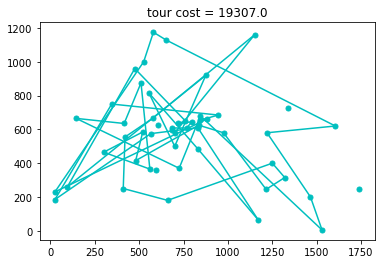

In [11]:
att48_atour = list(range(1,49))
att48_atour.append(1)

plot_tour(att48_atour, att48_coord, "tour cost = " + str(calc_tour_cost(att48_atour, att48_cost_mtx)))

We can see that this arbitrary tour is very poor, with many long links and large tour cost. Next, we will show how to improve it by local search.

## Local Search for TSP

---

The local search framework is described as follows.

```Python
def local_search_framework(problem):
    sol = initialise(problem)
    while not stop:
        neighbour = select_from_neighbourhood(sol, problem)
    
        if accept(neighbour, sol, problem):
            sol = neighbour
            
    return sol
```

The user-specified modules consist of

- The **initialisation** method
- The method to **select a neighbour** from the neighbourhood
- The **acceptance criteria** of the selected neighbour
- The **stopping criteria**

### Framework

For solving TSP, we can write the local search framework as follows. For the sake of simplicity, we design a basic "hill-climbing" local search, and fix the **neighbour acceptance** and **stopping criteria** to the following basic setting.

- **Neighbour Acceptance**: The selected neighbour is accepted if its cost is smaller than the current solution.
- **Stopping Criteria**: The local search stops if there is no improvement found.

In [12]:
import time

def local_search_tsp(coord, cost_mtx, initialisation, nb_selection, seed):
    '''
    The local search framework for solving TSP.
    :param coord, cost_mtx: The coordinates of the nodes and the cost matrix.
    :param initialisation: The initialisation method.
    :param nb_selection: The neighbour selection method.
    :param seed: the random seed, if the local search is a stochastic search.
    :return: The final tour and the log, which stores the elapsed time and best cost so far after each iteration.
    '''
    
    log = {'time': [], 'cost': []} # The log [elapse_time, best_cost]
    start = time.time()
    
    sol, sol_cost = initialisation(coord, cost_mtx, seed)
    
    improved = True
    while improved:
        improved = False

        nb, nb_cost = nb_selection(sol, sol_cost, coord, cost_mtx, seed)
        
        if sol_cost - nb_cost > 0.0000000001:
            sol, sol_cost = nb, nb_cost
            improved = True

        end = time.time()
        log['time'].append(end-start)
        log['cost'].append(sol_cost)

    return sol, sol_cost, log

### Initialisation

The TSP tour can be initialised randomly or using [greedy heuristics](https://github.com/meiyi1986/tutorials/blob/master/notebooks/tsp-greedy.ipynb). Here, we simply use random initialisation. The code is given below.

In [13]:
def random_tour(coord, cost_mtx, seed):
    tour = np.array(list(coord.keys())) # Get the node ids from the coordinates
    
    np.random.seed(seed)
    np.random.shuffle(tour) # Randomly shuffle the node ids
    
    tour = np.append(tour, tour[0]) # Add the start node to the end, to form a cycle
    
    tour_cost = calc_tour_cost(tour, cost_mtx)

    return tour, tour_cost

Now we can randomly generate a tour for the `a280.tsp` instance and plot it.

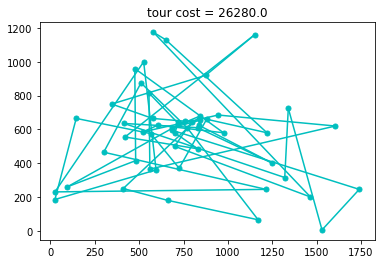

In [14]:
a280_coord = load_data("tsp/berlin52.tsp")
a280_cost_mtx = euclidean_distance_matrix(a280_coord)
a280_atour, a280_atour_cost = random_tour(a280_coord, a280_cost_mtx, 1)

plot_tour(a280_atour, a280_coord, "tour cost = " + str(a280_atour_cost))

### Neighbour Selection

The **neighbour selection**, as the key component in the local search algorithm, needs to answer the following two questions:

1. How to **define the neighbourhood**? That is, how to design the **move operators**?
2. How to **select a neighbour** from the neighbourhood?

#### 2-opt Neighbourhood

The 2-opt operator is a well-known move operator for improving TSP solutions. It selects a sub-list $[v_i, \dots, v_j]$ in the list, and reverse the nodes in the sub-list.

For example, given a solution `[1, 2, 3, 4, 5, 6, 7, 1]`, `i = 2` and `j = 5`, then the 2-opt operator will generate a new solution `[1, 2, 6, 5, 4, 3, 7, 1]`.

The 2-opt neighbourhood is defined as all the solutions that can be generated with all possible `i` and `j` values.

#### Select from Neighbourhood

Here we consider two neighbourhood selection schemes:

1. **Best Improvement**: we select the best neighbour from the neighbourhood.
2. **First Improvement**: we select the first neighbour we find to be better than the current solution.

Below we show the code for the **2-opt best improvement** and **2-opt first improvement** methods. they are very similar to each other, except that the best improvement method explores ALL the neighbours and returns the best neighbour in the neighbourhood. The first improvement method, on the other hand, returns a neighbour as soon as it is found to be better than the current solution.

> **NOTE**: We use a very small number 0.0000000001 to replace 0 as the threshold for improvement, to avoid the noisy effect of the computer calculation errors.

In [15]:
def two_opt_best_improvement(tour, tour_cost, coord, cost_mtx, seed):
    nb, nb_cost = tour, tour_cost
    best_change = 0
    best_i = None
    best_j = None
    
    # Since tour[0] = tour[-1], we doe not allow 2-opt between [0, 1] and [len-2, len-1]
    n1, n2 = tour[0], tour[1]
    for j in range(2,len(tour)-2):
        # The second removed edge [n3, n4]
        n3, n4 = tour[j], tour[j+1]

        # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
        # Calculate the cost change
        cost_change = cost_mtx[n1, n2] + cost_mtx[n3, n4] - cost_mtx[n1, n3] - cost_mtx[n2, n4]

        if cost_change > best_change:
            best_change = cost_change
            best_i = 0
            best_j = j
    
    # Enumerate from tour[1]. In this case, j can go to the end of the tour
    for i in range(1,len(tour)-2):
        # The first removed edge [n1, n2]
        n1, n2 = tour[i], tour[i+1]

        for j in range(i+2,len(tour)-1):
            # The second removed edge [n3, n4]
            n3, n4 = tour[j], tour[j+1]
            
            # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
            # Calculate the cost change
            cost_change = cost_mtx[n1, n2] + cost_mtx[n3, n4] - cost_mtx[n1, n3] - cost_mtx[n2, n4]
            
            if cost_change > best_change:
                best_change = cost_change
                best_i = i
                best_j = j
    
    # Actually change the tour if we found an improvement
    if best_change > 0.0000000001:
        # Change the tour, reverse the part [best_i+1, best_j]
        nb[best_i+1:best_j+1] = nb[best_i+1:best_j+1][::-1]
        nb_cost -= best_change
    
    return nb, nb_cost

In [16]:
def two_opt_first_improvement(tour, tour_cost, coord, cost_mtx, seed):
    nb, nb_cost = tour, tour_cost
    
    # Since tour[0] = tour[-1], we doe not allow 2-opt between [0, 1] and [len-2, len-1]
    n1, n2 = tour[0], tour[1]
    for j in range(2,len(tour)-2):
        # The second removed edge [n3, n4]
        n3, n4 = tour[j], tour[j+1]

        # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
        # Calculate the cost change
        cost_change = cost_mtx[n1, n2] + cost_mtx[n3, n4] - cost_mtx[n1, n3] - cost_mtx[n2, n4]

        if cost_change > 0.0000000001:
            # Change the tour, reverse the part [1, j]
            nb[1:j+1] = nb[1:j+1][::-1]
            nb_cost -= cost_change
            return nb, nb_cost
    
    # Enumerate from tour[1]. In this case, j can go to the end of the tour
    for i in range(1,len(tour)-2):
        # The first removed edge [n1, n2]
        n1, n2 = tour[i], tour[i+1]

        for j in range(i+2,len(tour)-1):
            # The second removed edge [n3, n4]
            n3, n4 = tour[j], tour[j+1]
            
            # Remove old edges [n1, n2] and [n3, n4], and add new edges [n1, n3] and [n2, n4]
            # Calculate the cost change
            cost_change = cost_mtx[n1, n2] + cost_mtx[n3, n4] - cost_mtx[n1, n3] - cost_mtx[n2, n4]
            
            if cost_change > 0.0000000001:
                # Change the tour, reverse the part [i+1, j]
                nb[i+1:j+1] = nb[i+1:j+1][::-1]
                nb_cost -= cost_change
                return nb, nb_cost
    
    return nb, nb_cost

## Solve an Example TSP Instance

---

Now, let's use the local search with random initialisation and 2-opt best improvement neighbour selection to solve the `a280.tsp` drilling TSP instance.

We can see that a reaonsably good solution is obtained after the local search, with the tour cost of 2827. The local search takes about 7 seconds to finish.

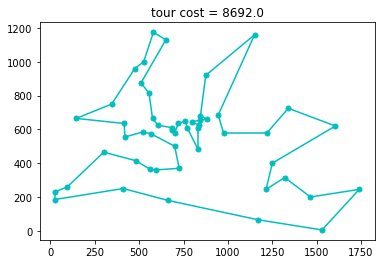

In [17]:
a280_coord = load_data("tsp/berlin52.tsp")
a280_cost_mtx = euclidean_distance_matrix(a280_coord)

two_opt_bi_tour, two_opt_bi_cost, two_opt_bi_log = local_search_tsp(a280_coord, 
                                                                    a280_cost_mtx, 
                                                                    random_tour, 
                                                                    two_opt_best_improvement, 
                                                                    seed = 1)

plot_tour(two_opt_bi_tour, a280_coord, "tour cost = " + str(two_opt_bi_cost))

Then, we use the local search with the **2-opt first improvement** method to solve the `a280.tsp` drilling TSP instance and plot the obtained solution. The local search takes about 11 seonds.

We can see that the **first improvement** obtains a better solution than the **best improvement** method (2674 vs 2827).

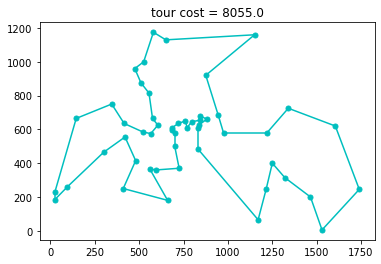

In [18]:
two_opt_fi_tour, two_opt_fi_cost, two_opt_fi_log = local_search_tsp(a280_coord, 
                                                                    a280_cost_mtx, 
                                                                    random_tour, 
                                                                    two_opt_first_improvement, 
                                                                    seed = 1)

plot_tour(two_opt_fi_tour, a280_coord, "tour cost = " + str(two_opt_fi_cost))

## Plot Convergence Curve

---

To show how the local search progresses over time, we can plot the convergence curve, where the x-axis is the elapse time and the y-axis is the best-so-far cost.

The method for plotting the convergence curves from a list of logs is shown as follows.

In [19]:
import matplotlib.pyplot as plt

def plot_convergence_curves(logs, names, title):
    fig, ax = plt.subplots()
    curves = []
    
    for log in logs:
        curve, = plt.plot(log['time'], log['cost'])
        curves.append(curve)
    
    plt.legend(curves, names)
    
    ax.set_xlabel("time (second)")
    ax.set_ylabel("cost")
    
    plt.title(title)
    plt.show()

We plot the convergence curves of the **2-opt best improvement** and **2-opt first improvement** local search as follows. We can see that the best improvement method improves the solution gradually and smoothly. On the other hand, the first improvement improves the solution much more quickly at the beginning, and then slows down substantially afterwards. It takes more longer than the best improvement, and finds a better final solution.

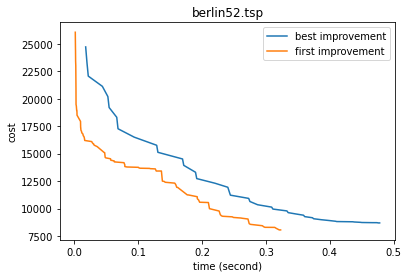

In [20]:
plot_convergence_curves([two_opt_bi_log, two_opt_fi_log], ['best improvement', 'first improvement'], 'berlin52.tsp')

## Summary

---

In this tutorial, we introduced how to design local search to solve the TSP. Specifically, we introduce the 2-opt operator to define the TSP neighbourhood, and the best/first improvement to select a neighbour from the 2-opt neighbourhood.

### Best or First Improvement?

It is hard to say whether best improvement or first improvement is better. Although first improvement updates the solutions more quickly, the amount of improvement each time is less than the best improvement, and it takes more iterations to reach the same solution quality as the best improvement.

In practice, this is typically chosen by trial and error, or from domain knowledge and experience.

### More Advanced Operators

The 2-opt operator introduced here is a very basic move operator. It deletes two edges and replaces them with two new edges. As a result, it defines a small neighbourhood with size of $O(n^2)$ around the current solution. Thus, it is easy to be trapped into local optima. To enhance the search capability and jump out of local optima, there are more advanced move operators developed, such as [3-opt](https://en.wikipedia.org/wiki/3-opt) and [Lin-Kernighan heuristics](https://en.wikipedia.org/wiki/Lin–Kernighan_heuristic).

---

- More tutorials can be found [here](https://github.com/meiyi1986/tutorials).
- [Yi Mei's homepage](https://meiyi1986.github.io/)